# Testing contour map 123

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import gcsfs
import gcm_filters
import xgcm
from xhistogram.xarray import histogram

In [2]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
cat = open_catalog(url)
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()
surf_ds  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
coord  = cat["GFDL_CM2_6_grid"].to_dask()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [3]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [4]:
mask = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/mask.zarr'))

In [5]:
atl_mask = mask.mask==0

In [6]:
selection = dict(xt_ocean=slice(-100, 30), yt_ocean=slice(-10, None))
salt = ds.salt.where(atl_mask).sel(**selection)
temp = ds.temp.where(atl_mask).sel(**selection)

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 64
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 64
  result = blockwise(


In [7]:
#rho = jmd95numba.rho(salt, temp, 0)
rho = xr.apply_ufunc(jmd95numba.rho, salt, temp, 0,
                              output_dtypes=[temp.dtype],
                              dask='parallelized').reset_coords(drop=True)
delta_rho = 0.1
rho_bins = np.arange(1015, 1030, delta_rho)

In [8]:
rho

<xarray.DataArray (time: 240, st_ocean: 50, yt_ocean: 1556, xt_ocean: 1300)>
dask.array<transpose, shape=(240, 50, 1556, 1300), dtype=float32, chunksize=(1, 5, 338, 450), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -99.95 -99.85 -99.75 ... 29.75 29.85 29.95
  * yt_ocean  (yt_ocean) float64 -9.999 -9.9 -9.802 -9.703 ... 89.89 89.94 89.98

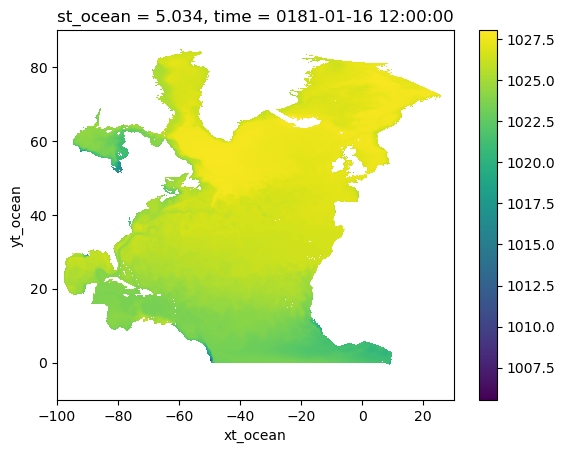

In [13]:
rho[0,0].plot()

In [11]:
rho = jmd95numba.rho(salt, temp, 0)

In [12]:
t = rho.isel(time=0).sel(xt_ocean=-40, method='nearest').compute()

(600.0, 0.0)

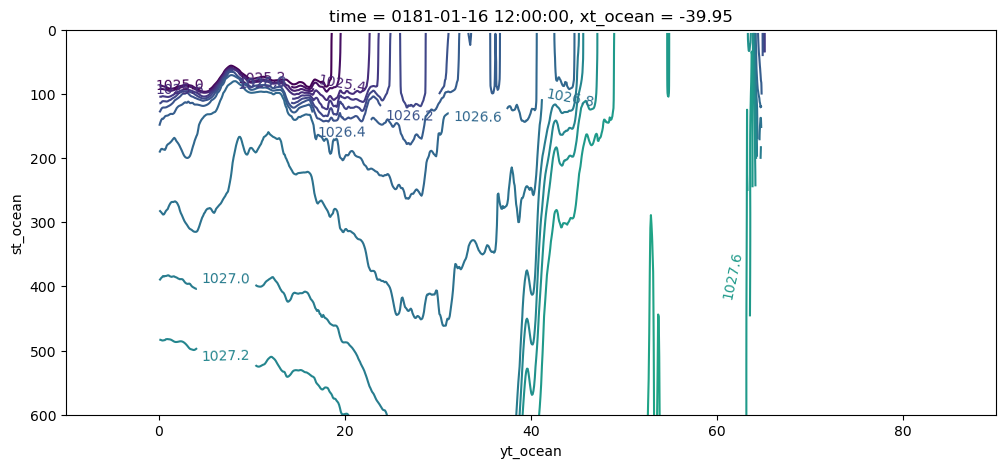

In [22]:
plt.figure(figsize=(12,5))
delta_rho = 0.2
rho_bins = np.arange(1025, 1030, delta_rho)
C = t.plot.contour(levels=rho_bins)
plt.clabel(C)
plt.ylim(600, 0)

(600.0, 0.0)

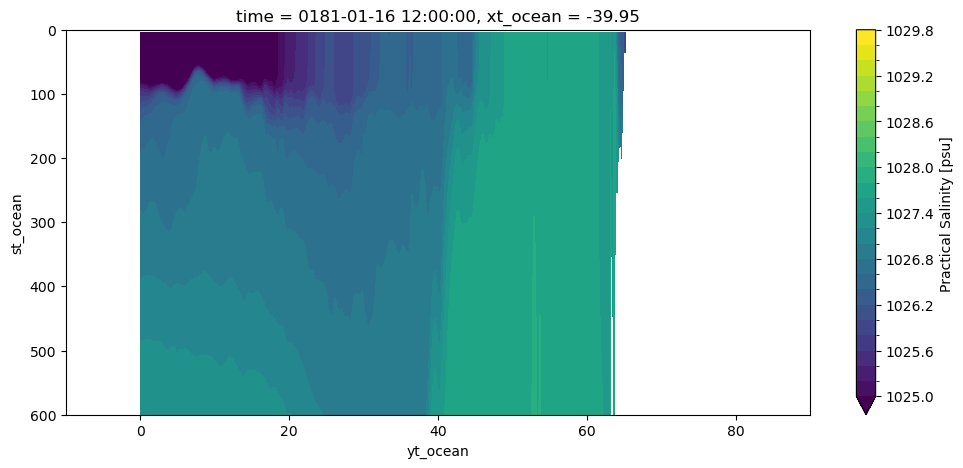

In [24]:
plt.figure(figsize=(12,5))
delta_rho = 0.2
rho_bins = np.arange(1025, 1030, delta_rho)
C = t.plot.contourf(levels=rho_bins)
plt.ylim(600, 0)

In [25]:
rho_bins

array([1025. , 1025.2, 1025.4, 1025.6, 1025.8, 1026. , 1026.2, 1026.4,
       1026.6, 1026.8, 1027. , 1027.2, 1027.4, 1027.6, 1027.8, 1028. ,
       1028.2, 1028.4, 1028.6, 1028.8, 1029. , 1029.2, 1029.4, 1029.6,
       1029.8])